<a href="https://www.kaggle.com/code/sentienttrapezoid/solar-power-plant?scriptVersionId=208421123" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/solar-power/Plant_2_Generation_Data.csv
/kaggle/input/solar-power/Plant_2_Weather_Sensor_Data.csv
/kaggle/input/solar-power/Plant_1_Weather_Sensor_Data.csv
/kaggle/input/solar-power/Plant_1_Generation_Data.csv


# TABLE OF CONTENTS
* [ENERGY FROM THE SUN](#chapter_1)
    * [Solar power plant](#section_1_1)
    * [Solar irradiance](#section_1_2)
* [LOADING LIBRARIES/DATA](#chapter_2)
* [EDA](#chapter_3)
    * [Efficiency](#section_3_1)
    * [Missing values](#section_3_2)
    * [Missing/Duplicate dates](#section_3_3)
    * [Correlation Matrix](#section_3_4)
    * [IRRADIATION - DC_POWER](#section_3_5)
    * [AMBIENT_TEMPERATURE - MODULE_TEMPERATURE](#section_3_6)
* [MODELS SET UP/PREDICTIONS](#chapter_4)
    * [Optimal hyperparameters search](#section_4_1)
    * [Predictions](#section_4_2)

<h2>ENERGY FROM THE SUN</h2><a id="chapter_1"></a>

Before addressing the data, we first recall some useful concepts about solar power generation:

<h3>Solar power plant</h3><a id="section_1_1"></a>

<img src = 'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2F4.bp.blogspot.com%2F-60ye2BnUV_U%2FVl8FZANXyvI%2FAAAAAAAABqQ%2FSR_wAbEe2Sw%2Fs1600%2Fgrid%252Bconnected%252BPV%252Bsolar%252Bsystem.jpg&f=1&nofb=1&ipt=3ab96505272ae286582c0a9ab0586acc0de3d20d5db93ae1b2c153f6bbaec4d7&ipo=images'>

Electricity can be produced by solar energy by either concentrated solar power system or photovoltaics.  
Photovoltaics generates electricity by means of the photoelectric effect, ehich happens when some material absorbs photons and emits free electrons.  
**Solar panels** are a frame of grouped photovoltaic cells which generate direct current at a certain voltage and with power ranging from hunderds to thousands of Watts, the solar panels outputs can be directly stored in batteries for later use, as common in off-grid solar plants, however, as most applications require alternate current, we need to convert dc to ac power using one or more **inverters**.  
While solar panels have the advantage to not employ the combustion of fossil fuels, they are dependent on **solar irradiance**.

<h3>Solar irradiance</h3><a id="section_1_2"></a>

With the term "solar irradiance" or solar insolation we refer to the amount of radiation from the Sun per unit area ($W\cdot m^{-2}$) impacts a location; of course this depends on numerous factors including:
<ul>
    <li>Hour in the day.</li>
    <li>The month (season) of detection.</li>
    <li>The location considered (longitude, latitude and altitude, coverage by shadow, slope and orientation...)</li>
    <li>The weather condition.</li>
</ul>
As a rough approximation, in clear sky conditions, we expect solar irradiance to be zero at night, increases up to a peak during central hours and then decreases:

<img src= 'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fadgeo.copernicus.org%2Farticles%2F45%2F139%2F2018%2Fadgeo-45-139-2018-f01-web.png&f=1&nofb=1&ipt=fc71d902ee35a488e79047d8af0a3b04864908b4f63ebdd5806f8fb5c09ebd17&ipo=images'>

A **peak sun hour** is defined as an hour when the solar irradiance averages on $1\,kW\cdot m^{-2}$.

<h2>LOADING LIBRARIES/DATA</h2><a id="chapter_2"></a>

In [2]:
import warnings
warnings.simplefilter(action='ignore')

import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import ipywidgets as widgets
from IPython.display import display, HTML

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from pandas.plotting import autocorrelation_plot, scatter_matrix

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor

In [3]:
def dec(text, sep=50):
    print('--'*sep)
    print(sep*' ' + text.upper())
    print('--'*sep)

We have two dataset, one regarding the plant data and one regarding the weather conditions detection (data available on <a>https://www.kaggle.com/datasets/pythonafroz/solar-power/data</a>):

In [4]:
power = pd.read_csv('/kaggle/input/solar-power/Plant_2_Generation_Data.csv', parse_dates=['DATE_TIME'])
weather = pd.read_csv('/kaggle/input/solar-power/Plant_2_Weather_Sensor_Data.csv', parse_dates=['DATE_TIME'])

display(power.tail())
display(weather.head())

DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
67693 2020-06-17 23:45:00   4136001  q49J1IKaHRwDQnt       0.0       0.0   
67694 2020-06-17 23:45:00   4136001  rrq4fwE8jgrTyWY       0.0       0.0   
67695 2020-06-17 23:45:00   4136001  vOuJvMaM2sgwLmb       0.0       0.0   
67696 2020-06-17 23:45:00   4136001  xMbIugepa2P7lBB       0.0       0.0   
67697 2020-06-17 23:45:00   4136001  xoJJ8DcxJEcupym       0.0       0.0   

       DAILY_YIELD  TOTAL_YIELD  
67693       4157.0     520758.0  
67694       3931.0  121131356.0  
67695       4322.0    2427691.0  
67696       4218.0  106896394.0  
67697       4316.0  209335741.0

DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0 2020-05-15 00:00:00   4136001  iq8k7ZNt4Mwm3w0            27.004764   
1 2020-05-15 00:15:00   4136001  iq8k7ZNt4Mwm3w0            26.880811   
2 2020-05-15 00:30:00   4136001  iq8k7ZNt4Mwm3w0            26.682055   
3 2020-05-15 00:45:00   4136001  iq8k7ZNt4Mwm3w0            26.500589   
4 2020-05-15 01:00:00   4136001  iq8k7ZNt4Mwm3w0            26.596148   

   MODULE_TEMPERATURE  IRRADIATION  
0           25.060789          0.0  
1           24.421869          0.0  
2           24.427290          0.0  
3           24.420678          0.0  
4           25.088210          0.0

<h3>What we know</h3>

A PV (photovoltaic) power plant produce electrical energy from solar radiation: 
<ul>
    <li>Photovoltaic panels converts solar radiation in direct current (<b>DC_POWER</b> in the power dataset)</li>
    <li>The direct power is converted in alternate current (<b>AC_POWER</b>) by one or more inverters (**SOURCE_KEY**)</li>
</ul>

<h3>What we expect</h3>

Assuming the assumptions above are correct we expect that:
<ul>
    <li>The <b>DC_POWER</b> should be positively correlated to the <b>IRRADIATION</b></li>
    <li>The <b>AC_POWER</b> should be positively correlated to the <b>DC_POWER</b></li>
</ul>

<h3>Our aim</h3>

<ul>
    <li>Build a model to predict the output power produce by the solar plant (target feature: AC_POWER).</li>
</ul>

<span style="color:red">**WARNING**: 
This notebook is still a work in progress, some section may lack extensive description, however the data analysis and the first draft of model selection/prediction is complete, <b>comments and suggestions are welcome!!!</b></span>

<h2>EDA</h2><a id="chapter_3"></a>

In [5]:
dec('power')
display(power.info())
dec('weather')
display(weather.info())

----------------------------------------------------------------------------------------------------
                                                  POWER
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67698 entries, 0 to 67697
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE_TIME    67698 non-null  datetime64[ns]
 1   PLANT_ID     67698 non-null  int64         
 2   SOURCE_KEY   67698 non-null  object        
 3   DC_POWER     67698 non-null  float64       
 4   AC_POWER     67698 non-null  float64       
 5   DAILY_YIELD  67698 non-null  float64       
 6   TOTAL_YIELD  67698 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 3.6+ MB


None

----------------------------------------------------------------------------------------------------
                                                  WEATHER
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3259 non-null   datetime64[ns]
 1   PLANT_ID             3259 non-null   int64         
 2   SOURCE_KEY           3259 non-null   object        
 3   AMBIENT_TEMPERATURE  3259 non-null   float64       
 4   MODULE_TEMPERATURE   3259 non-null   float64       
 5   IRRADIATION          3259 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 152.9+ KB


None

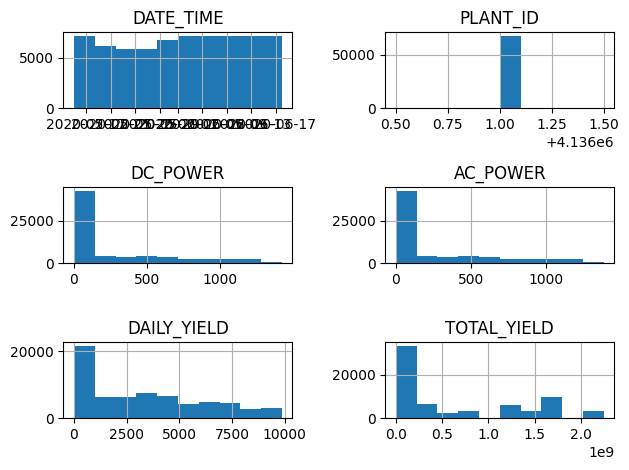

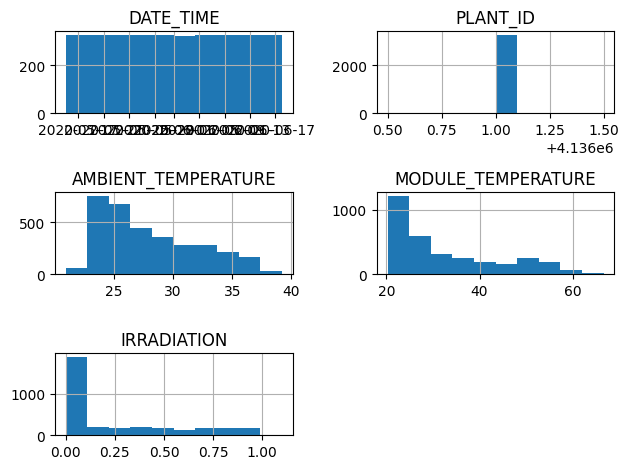

In [6]:
widget_power = widgets.Output()
widget_weather = widgets.Output()

with widget_power:
    power.hist()
    plt.tight_layout()
with widget_weather:
    weather.hist()
    plt.tight_layout()

layout = widgets.Layout(flex_flow = 'row', width='50%')
widget_box = widgets.HBox([widget_power, widget_weather])

widget_box

The PLANT_ID feature has only one values, therefore has no predictive power and we drop it, as well as the SOURCE_KEY for the weather dataset since the data is gathered by a single sensor type as shown below (WARNING: this data is not useful ONLY in a predictive sense, the information it conveys is still relevant):

In [7]:
dec('power')
display(power['SOURCE_KEY'].value_counts().sort_values(ascending=False))
dec('weather')
display(weather['SOURCE_KEY'].value_counts().sort_values(ascending=False))

----------------------------------------------------------------------------------------------------
                                                  POWER
----------------------------------------------------------------------------------------------------


SOURCE_KEY
xoJJ8DcxJEcupym    3259
q49J1IKaHRwDQnt    3259
WcxssY2VbP4hApt    3259
81aHJ1q11NBPMrL    3259
PeE6FRyGXUgsRhN    3259
oZZkBaNadn6DNKz    3259
V94E5Ben1TlhnDV    3259
LlT2YUhhzqhg5Sw    3259
LYwnQax7tkwH5Cb    3259
rrq4fwE8jgrTyWY    3259
vOuJvMaM2sgwLmb    3259
9kRcWv60rDACzjR    3259
oZ35aAeoifZaQzV    3195
4UPUqMRk7TRMgml    3195
Qf4GUc1pJu5T6c6    3195
Mx2yZCDsyf6DPfv    3195
Et9kgGMDl729KT4    3195
Quc1TzYxW2pYoWX    3195
mqwcsP2rE7J0TFp    2355
NgDl19wMapZy17u    2355
IQ2d7wF4YD8zU1Q    2355
xMbIugepa2P7lBB    2355
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------
                                                  WEATHER
----------------------------------------------------------------------------------------------------


SOURCE_KEY
iq8k7ZNt4Mwm3w0    3259
Name: count, dtype: int64

In [8]:
power.drop('PLANT_ID', axis=1, inplace=True)
weather.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1, inplace=True)

<h3>Efficiency</h3><a id="section_3_1"></a>

The inverter efficiency is defined as how much dc power is converted into ac power:  

 $\epsilon = \frac{P_{ac}}{P_{dc}}$   

(where $P_{ac}$ is the ac power and $P_{dc}$ is the dc power).  

In practice (and according to the laws of thermodynamics) is impossible to convert ALL dc power in ac power since some energy will be lost in the process, mainly due to:
<ul>
    <li>Heat loss</li>
    <li>Stand-by power (the inverter power consumption at no load condition.</li>
</ul>
To give an idea of typical efficiency values, an high-quality pure sine wave inverter has an efficiency $\epsilon \in [90\%, 95\%]$, while for low quality inverter $\epsilon \in [75\%, 85\%]$.  

Since we have no knowledge about the plant inverters (i.e, if they're  of the same kind/model of not) we calculate the efficiency for all of them as function of the output power:


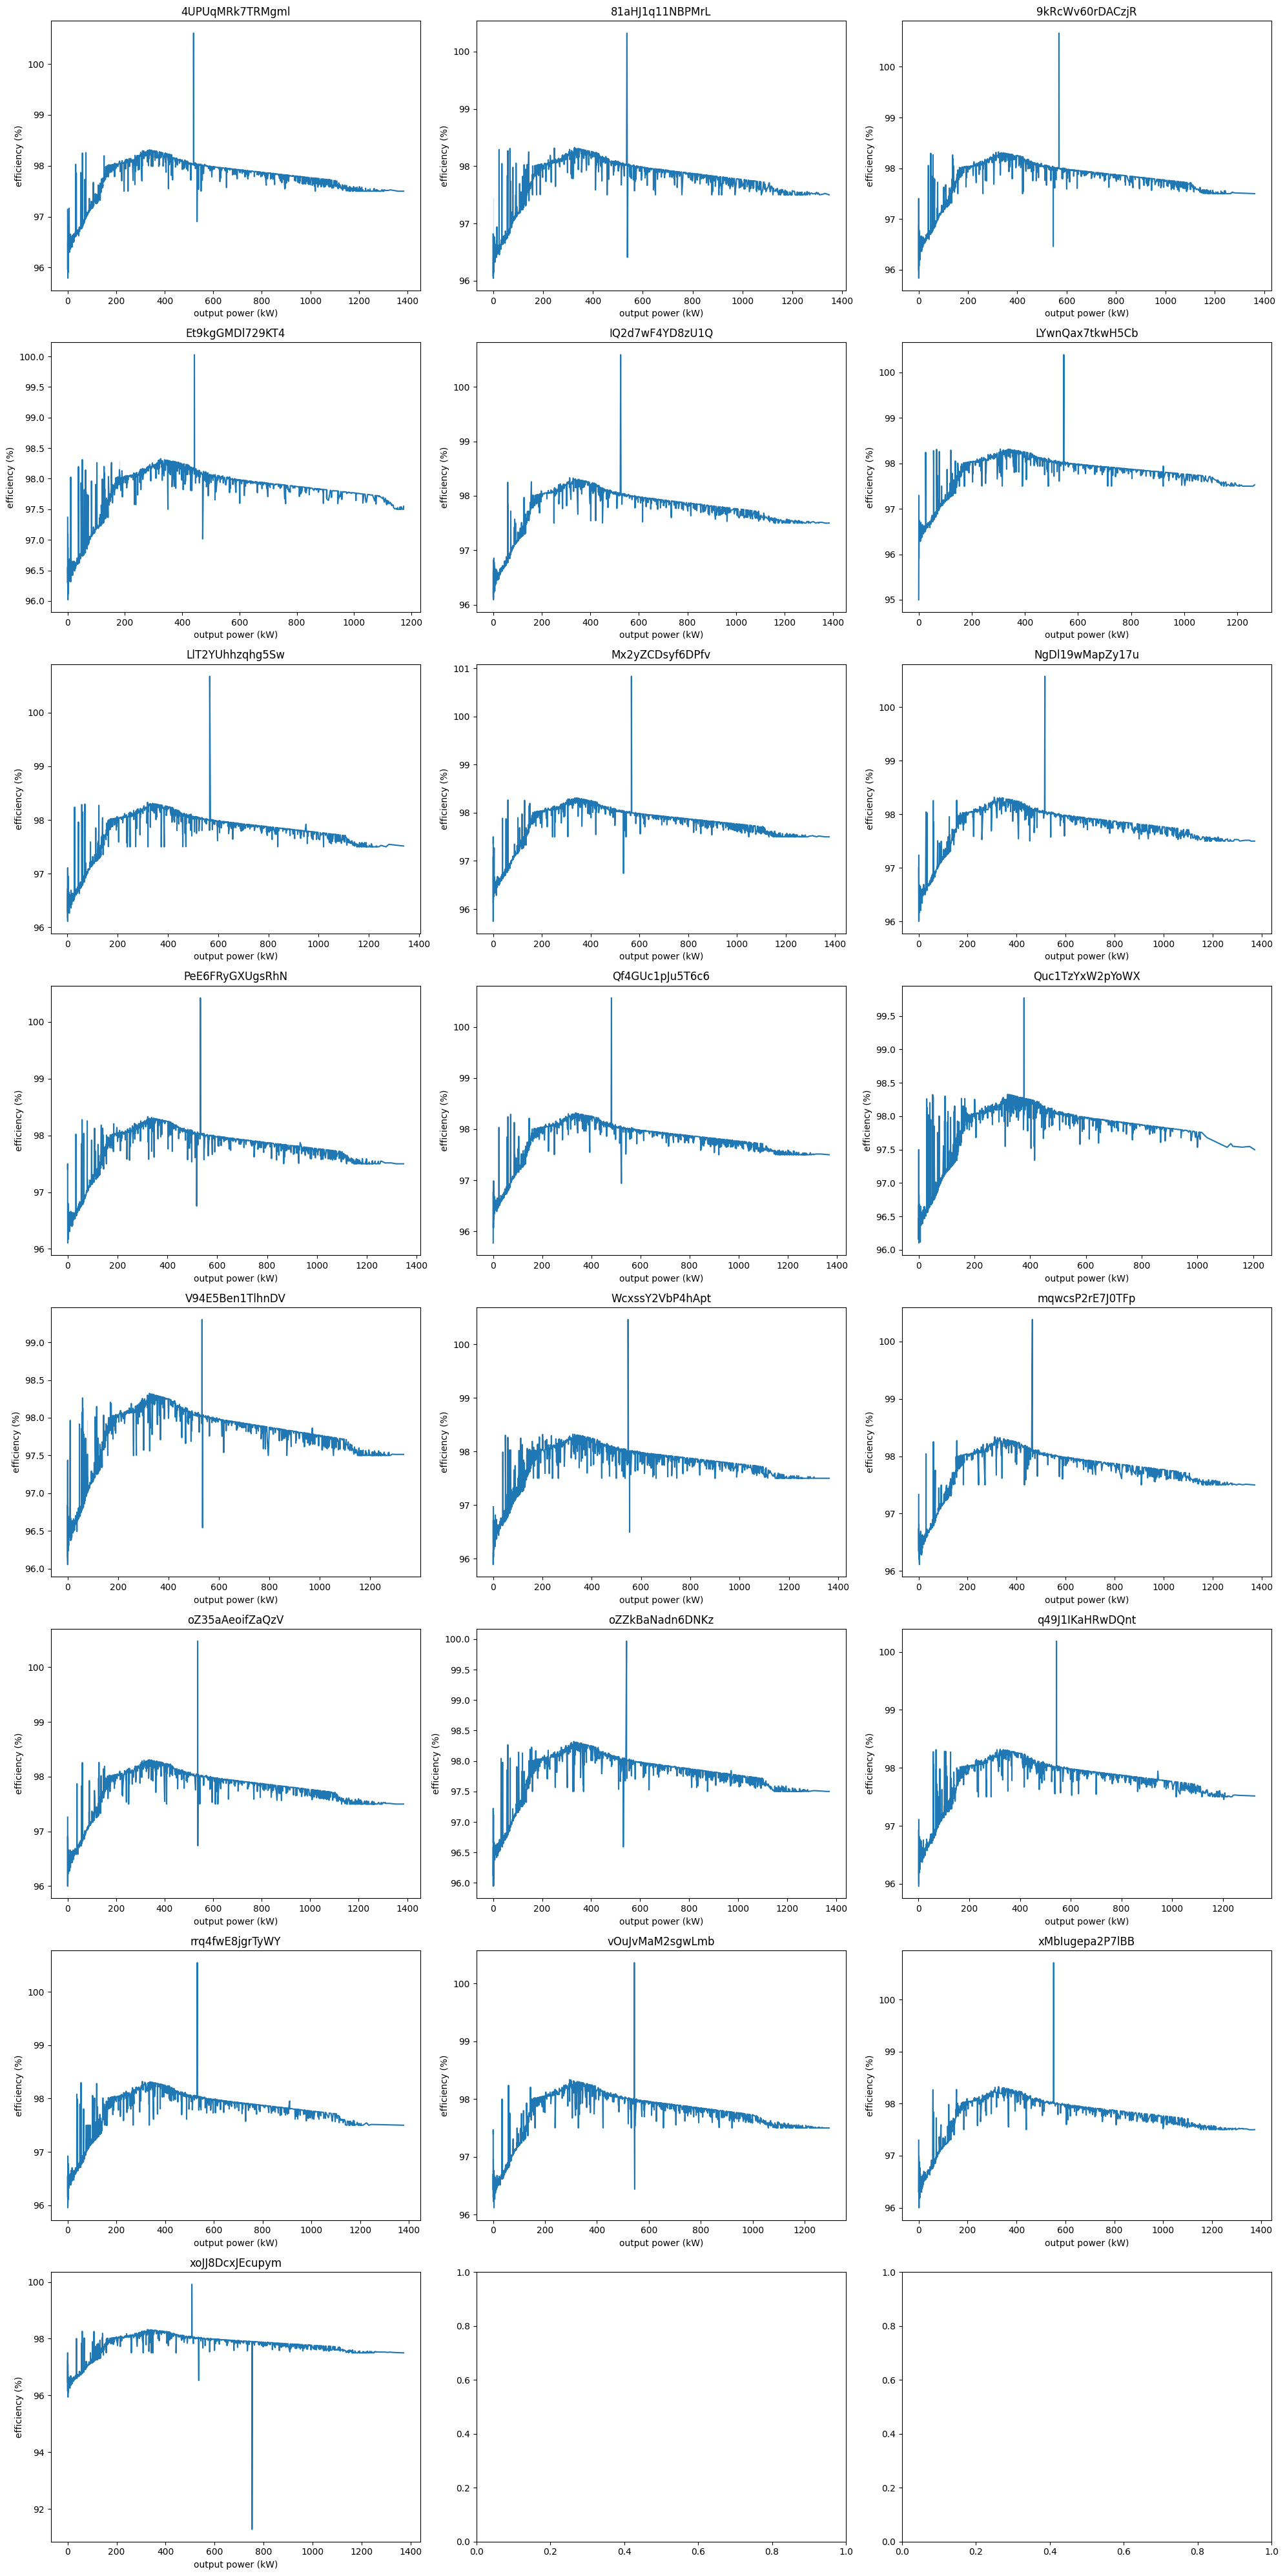

In [9]:
sk_num = power['SOURCE_KEY'].nunique()
rows = int(np.ceil(sk_num / 3.))

_, axes = plt.subplots(rows, 3, figsize = (20, 40))
for inverter, ax in zip(power['SOURCE_KEY'].unique(), axes.ravel()):
    inverter_df = power[(power['SOURCE_KEY'] == inverter) & (power['AC_POWER'] > 0.)]
    inverter_df['EFFICIENCY'] = 100 * (inverter_df['AC_POWER'] / inverter_df['DC_POWER'])
    sns.lineplot(data = inverter_df, x = 'AC_POWER', y = 'EFFICIENCY', ax = ax)
    ax.set_title(inverter)
    ax.set_xlabel('output power (kW)')
    ax.set_ylabel('efficiency (%)')
    del inverter_df
plt.tight_layout()
plt.show()

**Outtakes:**
<ul>
    <li>The inverters efficiency plots shows similar behaviour at the same range ($\epsilon \in [95.5\%, 98.5\%]$), indicating that they're probably of the same kind.</li>
    <li>The efficiency as function of the output energy behaves as expected: it increases up to a maximum value (corrisponding at $\hat{E}_{ac}\sim 300 kW$ and then slowly decreases. </li>
    <li>There is anomalous spike at around $E_{ac}\sim 500 kW$ (and one at $E_{ac}\sim 750 kW$ for the last plot), let's check for what entries these anomalies happen:</li>
</ul>

In [10]:
high_eff_dict = {'DATE_TIME' : [], 'DC_POWER' : [], 'AC_POWER' : [], 'EFFICIENCY' : []}
low_eff_dict = {'DATE_TIME' : [], 'DC_POWER' : [], 'AC_POWER' : [], 'EFFICIENCY' : []}

for inverter in power['SOURCE_KEY'].unique():
    inverter_df = power[(power['SOURCE_KEY'] == inverter) & (power['AC_POWER'] > 0.)]
    inverter_df['EFFICIENCY'] = 100 * (inverter_df['AC_POWER'] / inverter_df['DC_POWER'])
    high_inverter_df = inverter_df[inverter_df['EFFICIENCY'] > 99.]
    low_inverter_df = inverter_df[inverter_df['EFFICIENCY'] < 92]
    for key in high_eff_dict.keys():
        high_eff_dict[key] += high_inverter_df[key].tolist()
        low_eff_dict[key] += low_inverter_df[key].tolist()
    del inverter_df, high_inverter_df, low_inverter_df

display('HIGH EFFICIENCY SPIKES')
display(pd.DataFrame(high_eff_dict).sort_values(by = 'DATE_TIME'))
display('LOW EFFICIENCY SPIKES')
display(pd.DataFrame(low_eff_dict).sort_values(by = 'DATE_TIME'))

'HIGH EFFICIENCY SPIKES'

DATE_TIME    DC_POWER    AC_POWER  EFFICIENCY
0  2020-06-14 08:30:00  516.046667  519.185714  100.608288
19 2020-06-14 08:30:00  542.133333  544.071429  100.357494
18 2020-06-14 08:30:00  529.286667  532.164286  100.543679
17 2020-06-14 08:30:00  543.133333  544.135714  100.184555
16 2020-06-14 08:30:00  544.693333  544.521429   99.968440
15 2020-06-14 08:30:00  533.773333  536.321429  100.477374
14 2020-06-14 08:30:00  462.746667  464.514286  100.381984
13 2020-06-14 08:30:00  545.240000  547.750000  100.460348
12 2020-06-14 08:30:00  537.166667  533.421429   99.302779
11 2020-06-14 08:30:00  379.020000  378.150000   99.770461
10 2020-06-14 08:30:00  479.713333  482.428571  100.566013
9  2020-06-14 08:30:00  530.480000  532.728571  100.423875
8  2020-06-14 08:30:00  512.513333  515.471429  100.577174
7  2020-06-14 08:30:00  562.293333  566.971429  100.831967
6  2020-06-14 08:30:00  562.786667  566.585714  100.675042
5  2020-06-14 08:30:00  544.813333  546.942857  100.390872
4  2020-06-14 08:30:00  522.166667  525.235714  100.587752
3  2020-06-14 08:30:00  442.480000  442.600000  100.027120
2  2020-06-14 08:30:00  565.013333  568.764286  100.663870
1  2020-06-14 08:30:00  535.186667  536.907143  100.321472
20 2020-06-14 08:30:00  548.180000  552.057143  100.707276
21 2020-06-14 08:30:00  507.540000  507.114286   99.916122

'LOW EFFICIENCY SPIKES'

DATE_TIME    DC_POWER    AC_POWER  EFFICIENCY
0 2020-05-27 14:45:00  824.585714  752.673333   91.278968

We see that that the upward spike is detected at the same timestamp for all detectors.

Given the equivalence performance of the inverter and to have the same timestamps in both datasets, we sum the power features for all inverters at each (unique) datetime:

In [11]:
power_agg = power.drop('SOURCE_KEY', axis = 1).groupby('DATE_TIME').agg({'AC_POWER' : 'sum', 'DC_POWER' : 'sum','DAILY_YIELD' : 'sum', 'TOTAL_YIELD' : 'mean'})
power_agg = power_agg.reset_index()

In [12]:
power_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE_TIME    3259 non-null   datetime64[ns]
 1   AC_POWER     3259 non-null   float64       
 2   DC_POWER     3259 non-null   float64       
 3   DAILY_YIELD  3259 non-null   float64       
 4   TOTAL_YIELD  3259 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 127.4 KB


<h3>Missing values</h3><a id="section_3_2"></a>

Let's check for absent data (null/Nan values) in the dataset:

In [13]:
def missing_df(df):
    nan_df = (100 * df.isnull().sum() / len(df)).round(2)
    df_name = [x for x in globals() if globals()[x] is df][0]
    nan_df.name = df_name.upper() + ' Nan freq.(%)'
    return nan_df.sort_values(ascending=False)

dec('power')
display(missing_df(power))
dec('weather')
display(missing_df(weather))

----------------------------------------------------------------------------------------------------
                                                  POWER
----------------------------------------------------------------------------------------------------


DATE_TIME      0.0
SOURCE_KEY     0.0
DC_POWER       0.0
AC_POWER       0.0
DAILY_YIELD    0.0
TOTAL_YIELD    0.0
Name: POWER Nan freq.(%), dtype: float64

----------------------------------------------------------------------------------------------------
                                                  WEATHER
----------------------------------------------------------------------------------------------------


DATE_TIME              0.0
AMBIENT_TEMPERATURE    0.0
MODULE_TEMPERATURE     0.0
IRRADIATION            0.0
Name: WEATHER Nan freq.(%), dtype: float64

No null entries are detected.

<h3>Missing/Duplicate dates</h3><a id="section_3_3"></a>

We check if there are missing/duplicate dates in the DATE_TIME feature:

In [14]:
def check_missing_dates(df, start, end, freq):
    df_name = [x for x in globals() if globals()[x] is df][0]
    df_date_range = pd.date_range(start = start, end = end, freq=freq)
    missing_dates = df_date_range[~df_date_range.isin(df['DATE_TIME'])]
    print(df_name.upper() + ' MISSING DATES:')
    print('No missing dates!') if len(missing_dates) == 0 else print(f'{len(missing_dates)} dates missing:\n{missing_dates}')
    return missing_dates
    
def check_duplicate_dates(df):
    df_name = [x for x in globals() if globals()[x] is df][0]
    duplicate_vc = df['DATE_TIME'].value_counts()
    duplicate_vc = duplicate_vc[duplicate_vc > 1]
    print(df_name.upper() + ' DUPLICATE DATES:')
    print('No duplicate dates!') if len(duplicate_vc) == 0 else print(f'{len(duplicate_vc)} duplicate dates:\n{duplicate_vc}')
    return duplicate_vc

In [15]:
dec('power')
power_missing_dates = check_missing_dates(power_agg, '2020-05-15 00:00:00', '2020-06-17 23:45:00', freq='15min')
power_duplicate_dates = check_duplicate_dates(power_agg)
dec('weather')
weather_missing_dates = check_missing_dates(weather, '2020-05-15 00:00:00', '2020-06-17 23:45:00', freq='15min')
weather_duplicate_dates = check_duplicate_dates(weather)

----------------------------------------------------------------------------------------------------
                                                  POWER
----------------------------------------------------------------------------------------------------
POWER_AGG MISSING DATES:
5 dates missing:
DatetimeIndex(['2020-05-15 23:15:00', '2020-05-19 16:00:00',
               '2020-05-29 16:00:00', '2020-06-01 17:45:00',
               '2020-06-03 14:00:00'],
              dtype='datetime64[ns]', freq=None)
POWER_AGG DUPLICATE DATES:
No duplicate dates!
----------------------------------------------------------------------------------------------------
                                                  WEATHER
----------------------------------------------------------------------------------------------------
WEATHER MISSING DATES:
5 dates missing:
DatetimeIndex(['2020-05-15 23:15:00', '2020-05-19 16:00:00',
               '2020-05-29 16:00:00', '2020-06-01 17:45:00',
               '2020-

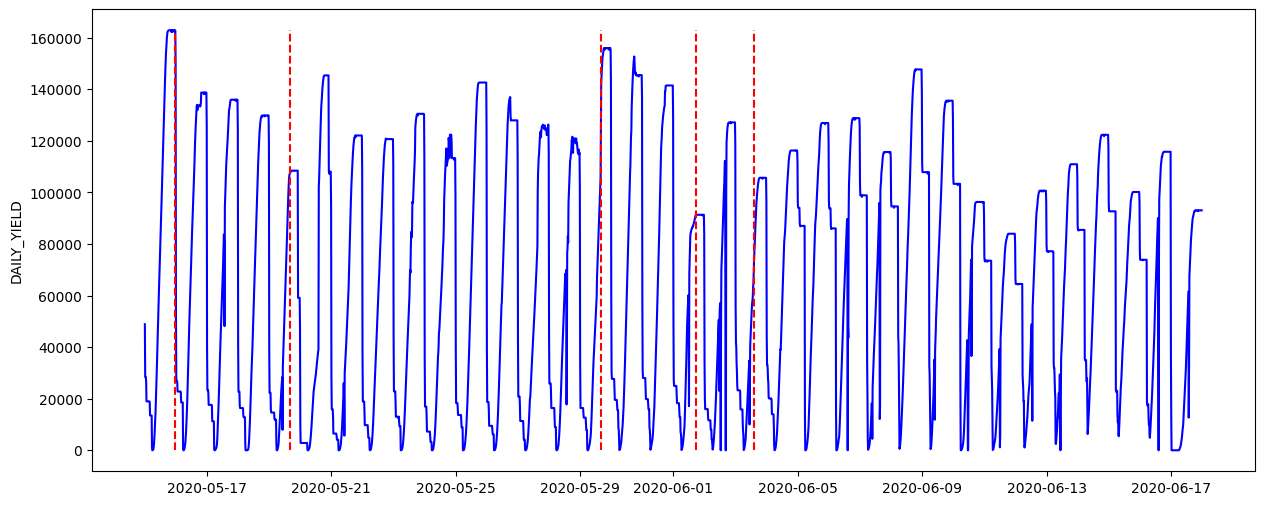

In [16]:
power_agg.set_index('DATE_TIME', inplace=True)
merged_power = power_agg.reindex(pd.date_range(start = '2020-05-15 00:00:00', end = '2020-06-17 23:45:00', freq='15min'))
missing_power_mask = np.where(np.isnan(merged_power['DAILY_YIELD']))[0]

_, ax = plt.subplots( figsize=(15,6))
sns.lineplot(x = merged_power.index, y = merged_power.DAILY_YIELD, color = 'blue', ax = ax)
plt.vlines( x = merged_power.index[missing_power_mask], ymin = merged_power['DAILY_YIELD'].min(), ymax = merged_power['DAILY_YIELD'].max(), color='red', linestyle = '--')
plt.show()

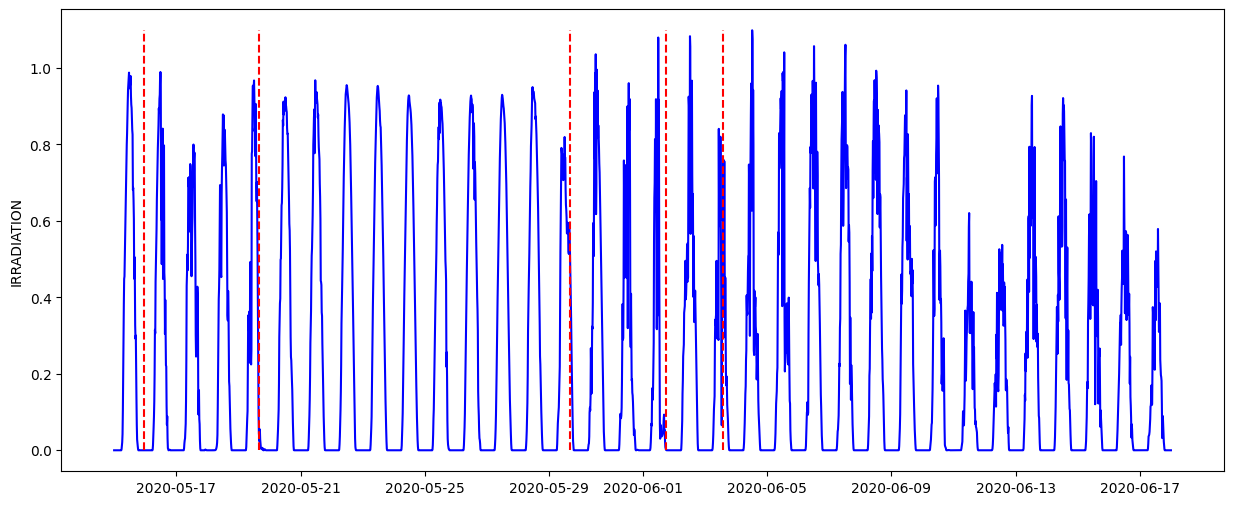

In [17]:
weather.set_index('DATE_TIME', inplace=True)
merged_weather = weather.reindex(pd.date_range(start = '2020-05-15 00:00:00', end = '2020-06-17 23:45:00', freq='15min'))
missing_weather_mask = np.where(np.isnan(merged_weather['IRRADIATION']))[0]

_, ax = plt.subplots( figsize=(15,6))
sns.lineplot(x = merged_weather.index, y = merged_weather.IRRADIATION, color = 'blue', ax = ax)
plt.vlines( x = merged_weather.index[missing_weather_mask], ymin = weather['IRRADIATION'].min(), ymax = weather['IRRADIATION'].max(), color='red', linestyle = '--')
plt.show()

The missing entries are few and separated: any filling method will do, in this case we use an piecewise polynomial interpolation:

In [18]:
filled_power = merged_power.interpolate(method = 'piecewise_polynomial')
filled_power.shape

(3264, 4)

In [19]:
filled_weather = merged_weather.interpolate(method = 'piecewise_polynomial')
filled_weather.shape

(3264, 3)

For ease of use we join the two dataset together:

In [20]:
df = filled_power.join(filled_weather)
df.head()

AC_POWER  DC_POWER   DAILY_YIELD   TOTAL_YIELD  \
2020-05-15 00:00:00       0.0       0.0  48899.938095  6.449816e+08   
2020-05-15 00:15:00       0.0       0.0  28401.000000  6.449816e+08   
2020-05-15 00:30:00       0.0       0.0  28401.000000  6.449816e+08   
2020-05-15 00:45:00       0.0       0.0  28401.000000  6.449816e+08   
2020-05-15 01:00:00       0.0       0.0  26516.000000  6.449816e+08   

                     AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  
2020-05-15 00:00:00            27.004764           25.060789          0.0  
2020-05-15 00:15:00            26.880811           24.421869          0.0  
2020-05-15 00:30:00            26.682055           24.427290          0.0  
2020-05-15 00:45:00            26.500589           24.420678          0.0  
2020-05-15 01:00:00            26.596148           25.088210          0.0

To be (extra) sure that the DATE_TIME timestamps were the same for both datasets we check for the presence of missing values:

In [21]:
display(missing_df(df))

AC_POWER               0.0
DC_POWER               0.0
DAILY_YIELD            0.0
TOTAL_YIELD            0.0
AMBIENT_TEMPERATURE    0.0
MODULE_TEMPERATURE     0.0
IRRADIATION            0.0
Name: DF Nan freq.(%), dtype: float64

The dataset has now unique timestamps, no null entries and no missing dates.

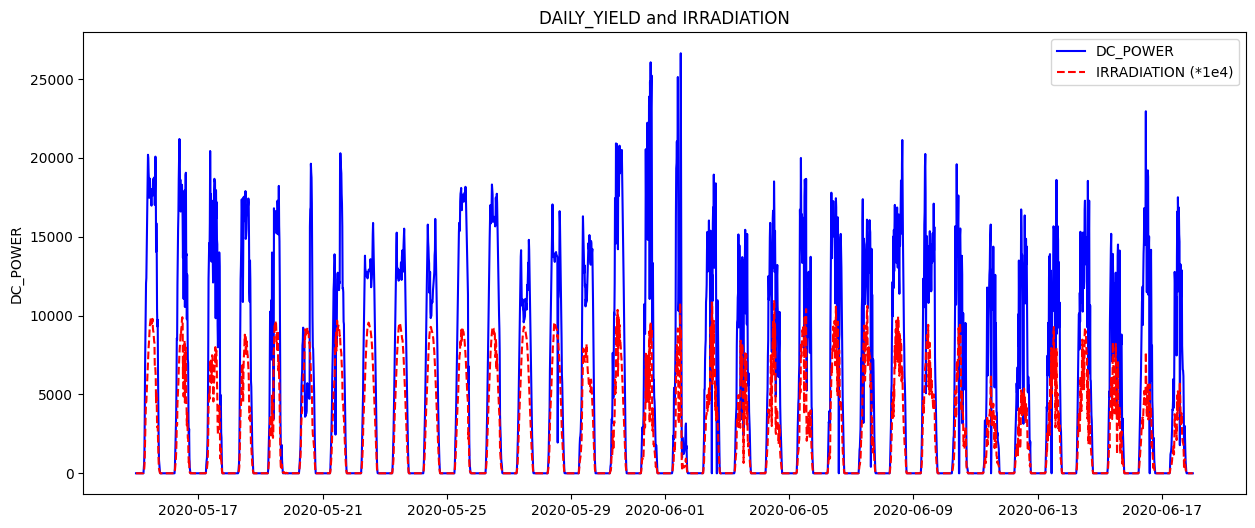

In [22]:
_, ax = plt.subplots(figsize = (15,6))
sns.lineplot(data = df, x = df.index, y = 'DC_POWER', color = 'blue', label = 'DC_POWER', ax = ax)
sns.lineplot( x = df.index, y = df['IRRADIATION']*(1e4), color = 'red', linestyle = '--', label = 'IRRADIATION (*1e4)', ax = ax)
ax.set_title('DAILY_YIELD and IRRADIATION')
plt.legend()
plt.show()

<h3>Correlation Matrix</h3><a id="section_3_4"></a>

We check the correlation between feature:

<Axes: >

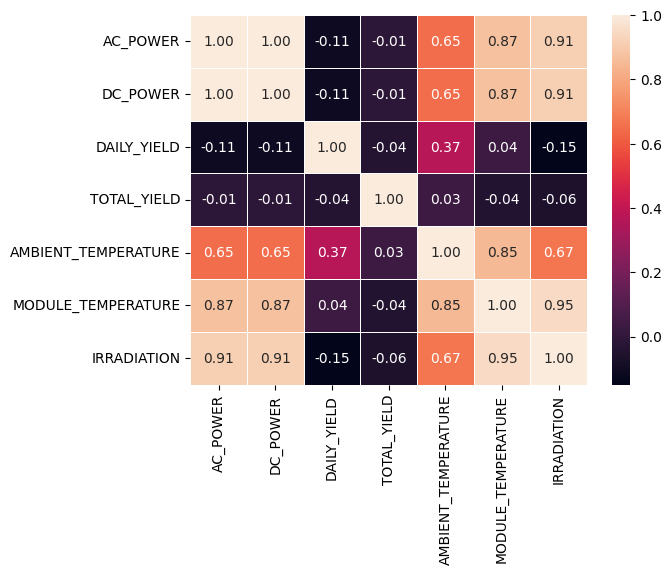

In [23]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', linewidth = 0.5)

In [24]:
corr_matrix['AC_POWER'].sort_values(ascending=False)

AC_POWER               1.000000
DC_POWER               0.999996
IRRADIATION            0.911141
MODULE_TEMPERATURE     0.872047
AMBIENT_TEMPERATURE    0.648418
TOTAL_YIELD           -0.011278
DAILY_YIELD           -0.109584
Name: AC_POWER, dtype: float64

We observe that:
<ul>
    <li>dc and ac power have an almost perfect positive linear correlation (at least according to the pearson correlation coefficient): as explained before the coefficient of this linear correlation is the efficiency, which, while technically a function of the power output, is roughly constant in the power range considered.</li>
    <li>There is a significant linear correlation between AC_POWER and IRRADIATION (as expected),MODEL_TEMPERATURE and AMBIENT_TEMPERATURE, these features however may be redundant, since they're correlated as well.</li>
</ul>                             

<h3>IRRADIATION - DC_POWER</h3><a id="section_3_5"></a>

We visualize the correlation between irradiation and dc power by plotting their value for each day:

In [25]:
min_list = ['00', '15', '30', '45']
hour_list = [str(x) for x in range(24)] 
time_array = np.array([x + ':' + y for x in hour_list for y in min_list])

def day_2plots(df,  cols_list):
    if len(cols_list) != 2:
        raise ValueError(f'The function accepts only 2 features to plot, {len(cols_list)} were given.')
    col0, col1 = cols_list[0], cols_list[1]
    days_df = [group[1] for group in df.groupby(df.index.date)]
    rows = int(np.ceil(len(days_df)/3.))
    _, axes = plt.subplots(rows, 3, figsize = (20, 40))
    for day_df, ax in zip(days_df, axes.ravel()):
        sns.lineplot(x = time_array, y = day_df[col0], ax = ax, color = 'red', label = col0)
        ax.set_ylim(day_df[col0].min(), 1.05*day_df[col0].max())
        ax2 = ax.twinx()
        sns.lineplot(x = time_array, y = day_df[col1], ax = ax2, color = 'blue', alpha = 0.6, label = col1)
        ax2.set_ylim(day_df[col1].min(), 1.05*day_df[col1].max())
        ax2.tick_params(axis='y', color = 'blue')
        ax.set_title(day_df.index.date[0])
        ax.xaxis.set_major_locator(ticker.MultipleLocator(base=16))
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc=0)
    plt.tight_layout()
    plt.suptitle(f'Day plots of {col0} and {col1} features', fontsize=20, y=1.02)
    plt.show()
    del days_df

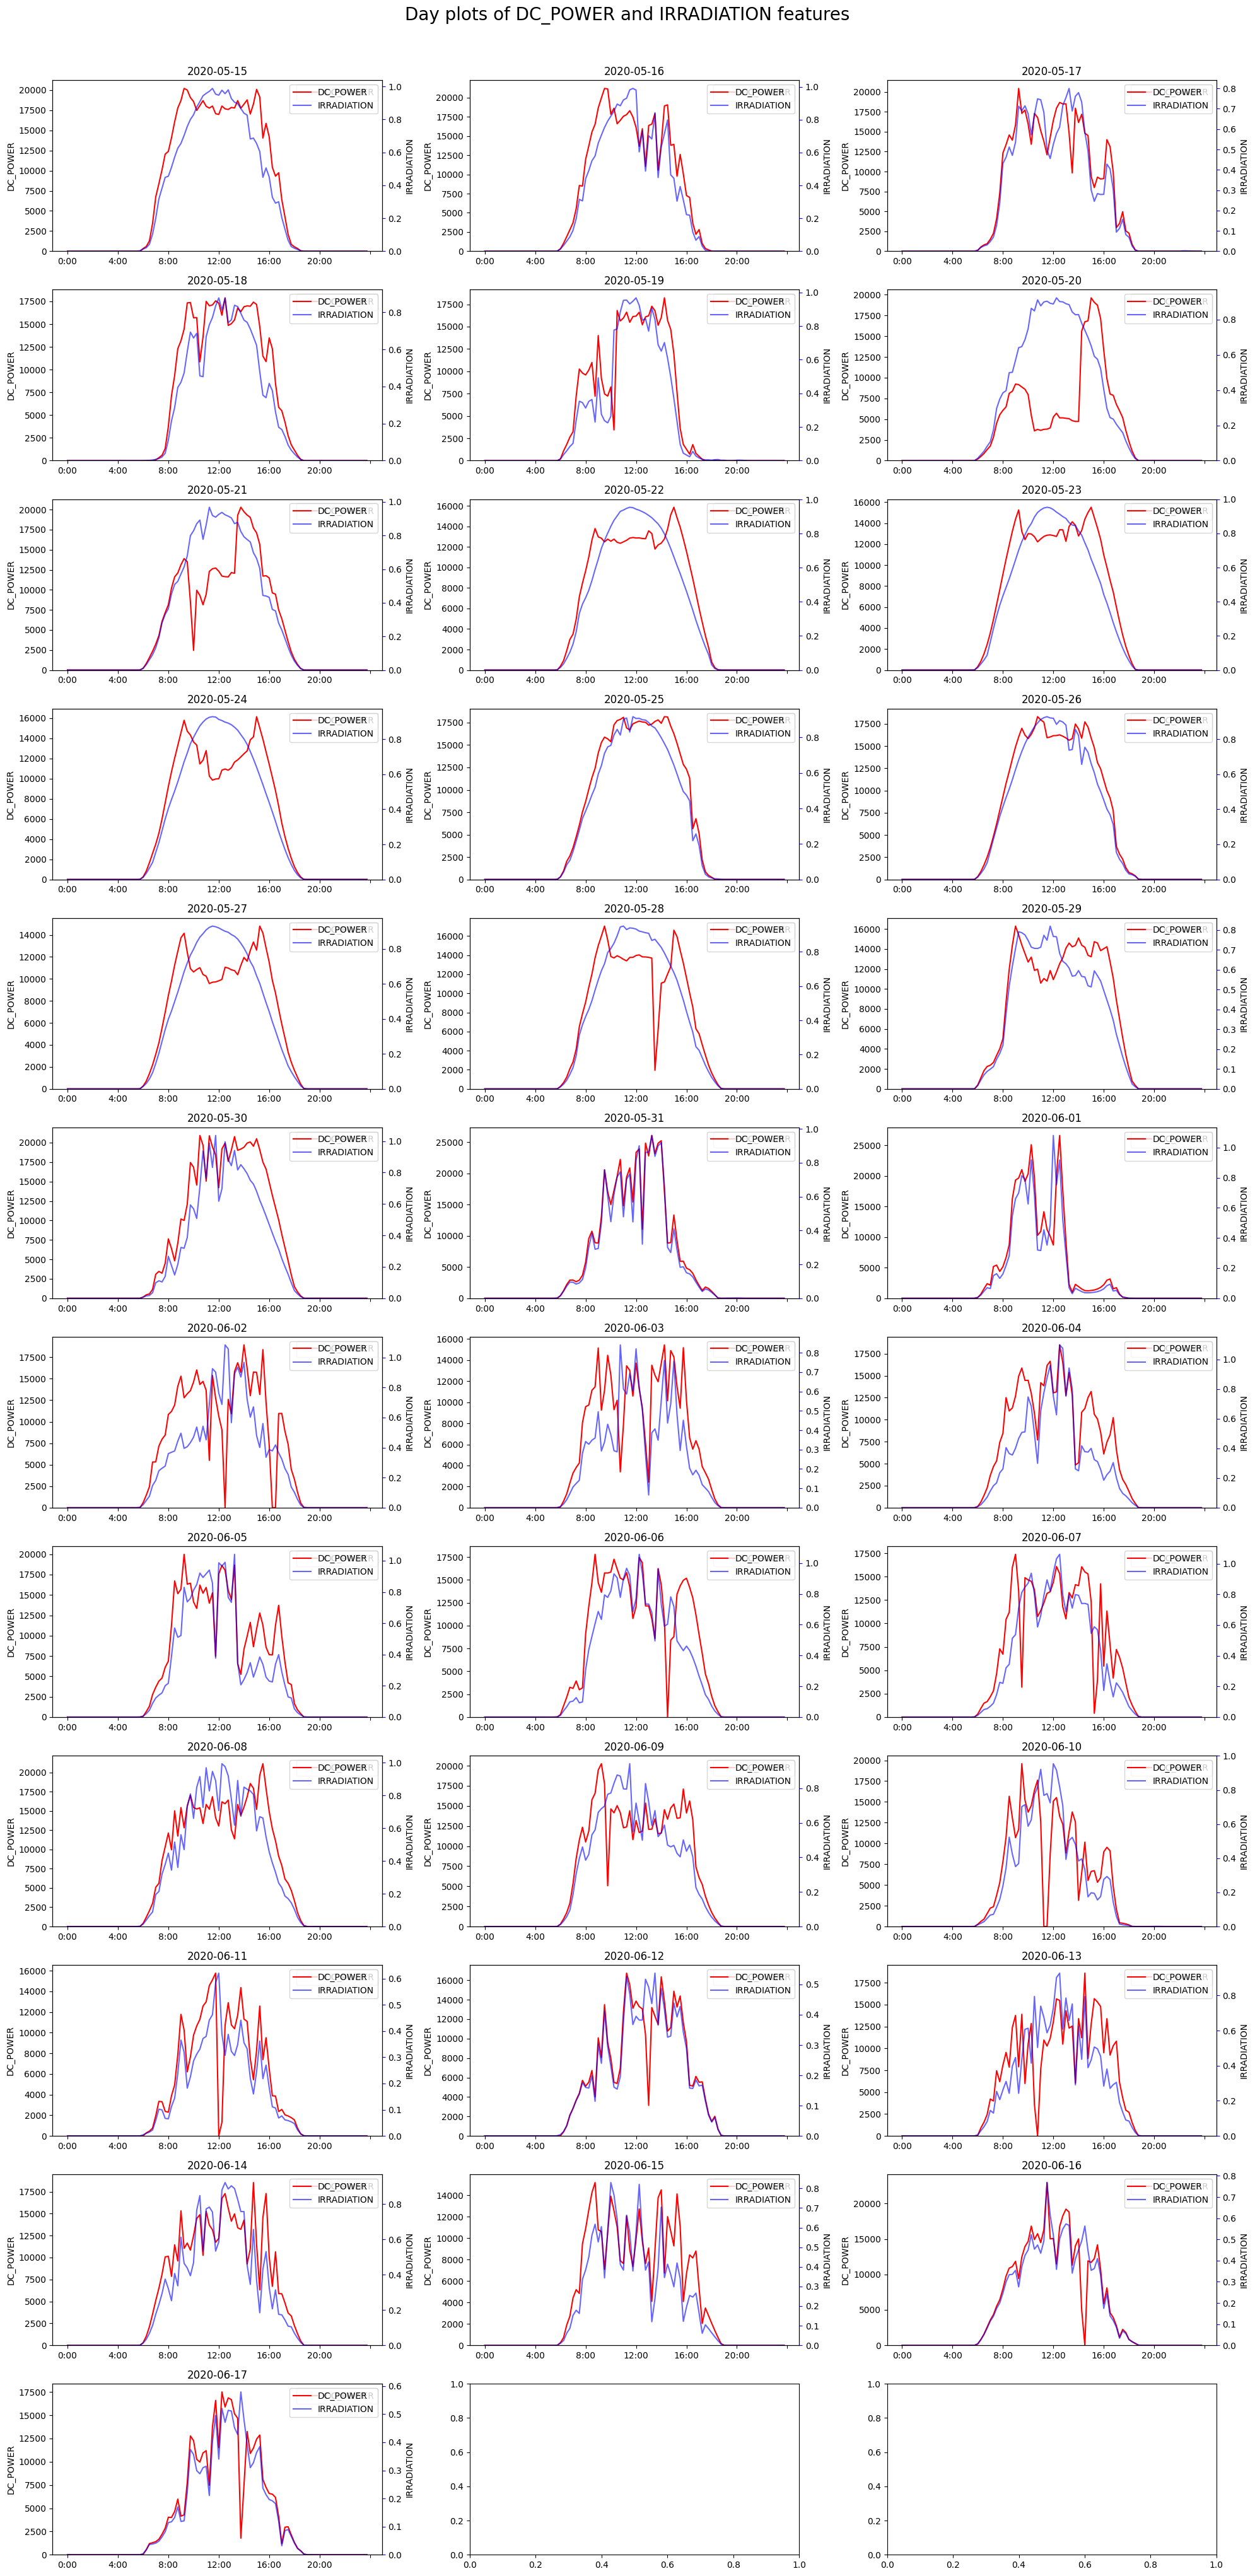

In [26]:
day_2plots(df, ['DC_POWER', 'IRRADIATION'])

**Outtakes:**
<ul>
    <li>On average the power produced follow closely the irradiation profile.</li>
    <li>In some days (May 25 and 26) the dc power and irradiation plot is very close to the ideal behaviour, others (the 15th, 22th, 23th, 24th and 27th) the irradiation is bell shaped, while the dc power goes flat at peak sun hours. </li>
    <li>In some cases the dc power dropped abruptly, most of times its due to a corresponding drop in irradiation (likely due to cloudy or rainy weather), but we recognize also uncorrelated drops for example at May 21th, 28th, June the 2nd, 6th, from 10th to 14th, 16th and 17th; in particular May 5th is the most anomalous day, with high irradiance, but low dc power for most of sunlight hour. </li>
</ul>

<h3>AMBIENT_TEMPERATURE - MODULE_TEMPERATURE</h3><a id="section_3_6"></a>

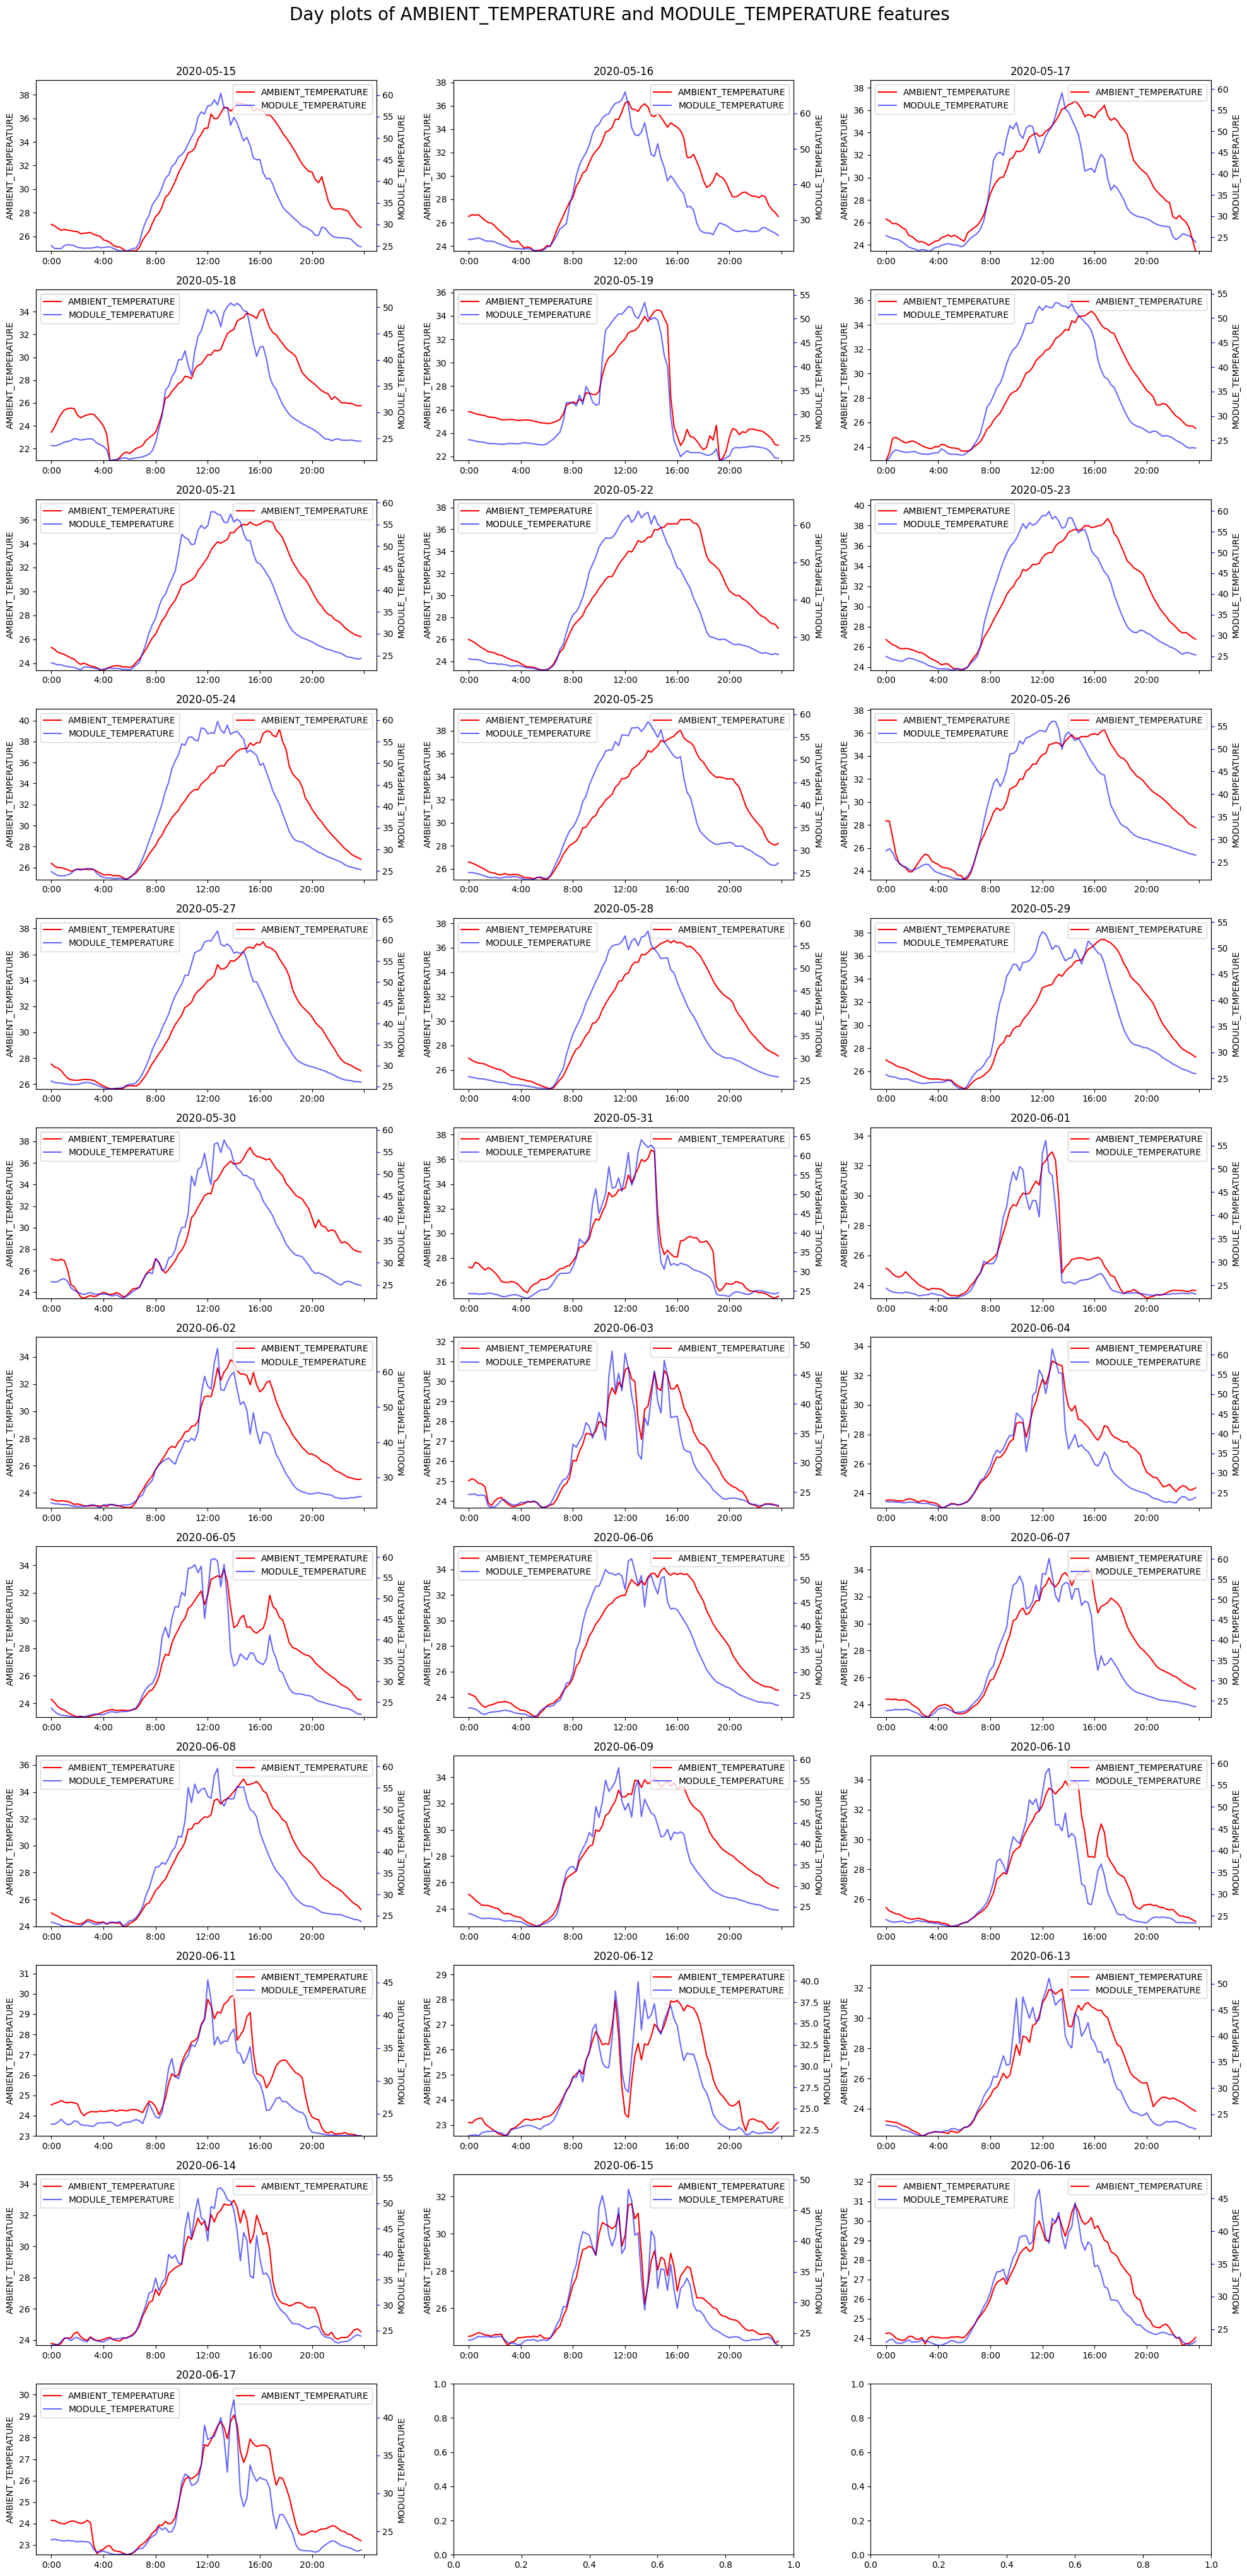

In [27]:
day_2plots(df, ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE'])

<h2>MODELS SET UP/PREDICTIONS</h2><a id="chapter_4"></a>

Our target is the power fed into the grid (AC_POWER), as independent variable we first limit at AMBIENT_TEMPERATURE and IRRADIANCE since:
<ul>
    <li>They are strogly correlated with the target.</li>
    <li>Others feature could overconstrain the model.</li>
    <li>These features are possible data that could be predicted in a weather forecast, therefore they can be use to predict future power outputs (unlike MODULE_TEMPERATURE which can only be estimated at detection time) </li>
</ul>  
We therefore divide the dataset in a training dataset and a testing dataset with the latest dates in the DATE_TIME timestamps:

In [28]:

X = df[['AMBIENT_TEMPERATURE', 'IRRADIATION']]
y = df['AC_POWER']

TEST_SIZE = int(0.2*len(df))

X_train, X_test = X.iloc[: - TEST_SIZE, :], X.iloc[-TEST_SIZE : , :]
y_train, y_test = y[: -TEST_SIZE], y[-TEST_SIZE :] 

<h3>Optimal hyperparameters search</h3><a id="section_4_1"></a>

We perform a grid search for three regression model:
<ul>
    <li>Lasso</li>
    <li>Radom Forest</li>
    <li>XGBRegressor</li>
</ul>

In [29]:
preprocessor_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

model_dict = {
    'LASSO' : Lasso(),
    'RFR' : RandomForestRegressor(),
    'XGBR' : XGBRegressor()
}

ls_params = {'model__alpha' : [0.01, 0.1, 1., 10.]}
rfr_params = {'model__n_estimators' : [3, 5, 10], 'model__max_depth' : [4, 6, 8]}
xgbr_params = {'model__learning_rate' : [0.05, 0.1, 0.3], 'model__max_depth' : [3, 5, 7]}

grid_params = {
    'LASSO' : ls_params,  
    'RFR' : rfr_params,
    'XGBR' : xgbr_params
}

In [30]:
i = 0

model_best_params = model_dict.copy()

grid_results = pd.DataFrame({'MODEL' : model_dict.keys(), 'BEST_SCORE' : np.zeros(len(model_dict)), 'BEST_PARAMS' : np.zeros(len(model_dict)), 'TRAINING_TIME' : np.zeros(len(model_dict))})

for key, model in model_dict.items():
    
    with warnings.catch_warnings():     
        warnings.simplefilter('ignore', category=ConvergenceWarning)
        
        print(model)
        full_pipeline = Pipeline(
            [
                ('preprocessor', preprocessor_pipeline),
                ('model', model)
            ]
        )
        
        start = time.time()
        model_gscv = GridSearchCV(estimator = full_pipeline, param_grid = grid_params[key], cv =5, scoring = 'neg_mean_squared_error', n_jobs=-1)
        model_gscv.fit(X_train, y_train)
        stop = time.time()

        grid_results.iloc[i, 1] = model_gscv.best_score_
        grid_results.iloc[i, 2] = str(model_gscv.best_params_)
        grid_results.iloc[i, 3] = np.round(stop - start, 2)

        model_best_params[key] = model_gscv.best_params_

        print('Model: ', key)
        print('Training time (s): ', grid_results.iloc[i,3])
        print('')

        i += 1     

Lasso()
Model:  LASSO
Training time (s):  2.27

RandomForestRegressor()
Model:  RFR
Training time (s):  0.57

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Model:  XGBR
Training time (s):  1.42



In [31]:
display(grid_results)
display(model_best_params)

MODEL    BEST_SCORE                                        BEST_PARAMS  \
0  LASSO -7.159071e+06                             {'model__alpha': 10.0}   
1    RFR -4.419776e+06  {'model__max_depth': 4, 'model__n_estimators': 3}   
2   XGBR -4.486390e+06  {'model__learning_rate': 0.05, 'model__max_dep...   

   TRAINING_TIME  
0           2.27  
1           0.57  
2           1.42

{'LASSO': {'model__alpha': 10.0},
 'RFR': {'model__max_depth': 4, 'model__n_estimators': 3},
 'XGBR': {'model__learning_rate': 0.05, 'model__max_depth': 3}}

The random forest is the model with the best performance, followed closely by the XGBRegressor.

<h3>Predictions</h3><a id="section_4_2"></a>

We train the RandomForestRegressor on the whole training dataset with the best parameters estimated above:

In [32]:
best_model = RandomForestRegressor(n_estimators = 3, max_depth = 4)
best_pipeline = Pipeline([
    ('preprocessor', preprocessor_pipeline),
    ('model', best_model)
])

best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)

print('Root mean squared error: ', np.sqrt(mean_squared_error(predictions, y_test)))

Root mean squared error:  1841.100509441416


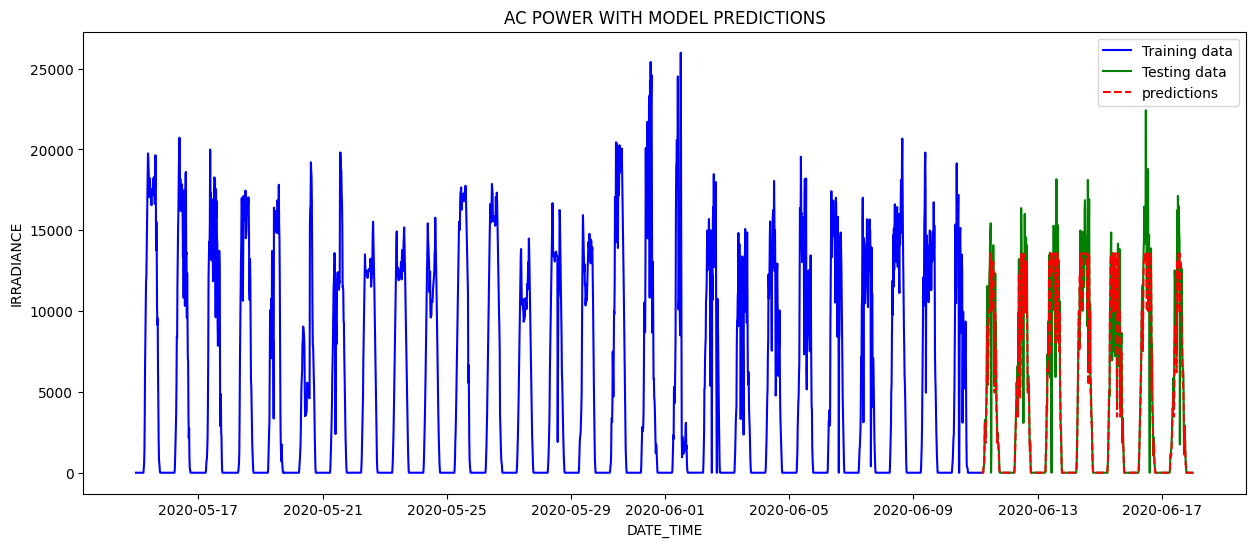

In [33]:
_, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = df.index[:-TEST_SIZE] , y = y_train, color = 'blue', label = 'Training data', ax = ax)
sns.lineplot(x = df.index[-TEST_SIZE : ] , y = y_test, color = 'green', label = 'Testing data', ax = ax)
sns.lineplot(x = df.index[-TEST_SIZE : ] , y = predictions, color = 'red', linestyle = '--', label = 'predictions', ax = ax)
ax.set_xlabel('DATE_TIME')
ax.set_ylabel('IRRADIANCE')
ax.set_title('AC POWER WITH MODEL PREDICTIONS')
plt.legend()
plt.show()

The model is able to follow the cyclic behaviour of the power outputs, however it tends to underestimate the peak values of ac power output.